In [1]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

def printmd(string):
    display(Markdown(string))
        

import os

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler  
from folktables import ACSDataSource, ACSPublicCoverage

In [2]:
SENSITIVE_CODE_0 = 0
SENSITIVE_CODE_1 = 1
SENSITIVE_CODE_2 = 2

In [3]:
def preprocess_data():

    data_source = ACSDataSource(survey_year=2018, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=["CA"], download=True)

    ca_features, ca_labels, _ = ACSPublicCoverage.df_to_pandas(acs_data)

    ca_features_filt = ca_features[(ca_features['RAC1P'] == 1) | (ca_features['RAC1P'] == 2) | (ca_features['RAC1P'] == 6)]
    ca_labels_filt = ca_labels[(ca_features['RAC1P'] == 1) | (ca_features['RAC1P'] == 2) | (ca_features['RAC1P'] == 6)]
    ca_features_filt['RAC1P'] = ca_features_filt['RAC1P'].replace({1: 0, 2: 2, 6: 1})
    ca_features_filt['SEX'] = ca_features_filt['SEX'].replace({1: 0, 2: 1})

    # filterning based on non-numeric values
    ca_features_filt[ca_features_filt.select_dtypes(include='object').any(axis=1)]
    ca_labels_filt[ca_features_filt.select_dtypes(include='object').any(axis=1)]

    ###### Create coverage bins
    pincp_column = ca_features_filt["PINCP"]
    # Calculate bin size
    bin_size = (pincp_column.max() - pincp_column.min()) / 10
    # Create bins
    bins = np.arange(pincp_column.min(), pincp_column.max() + bin_size, bin_size)
    # Assign values to bins
    pincp_bins = pd.cut(pincp_column, bins=bins, labels=False)
    # Add new column
    ca_features_filt["PINCP_cat"] = pincp_bins

    ###### Create age bins
    # Assuming 'ca_features_filt' is your DataFrame
    age_column = ca_features_filt["AGEP"]
    # Calculate bin size
    bin_size = (age_column.max() - age_column.min()) / 5
    # Create bins
    bins = np.arange(age_column.min(), age_column.max() + bin_size, bin_size)
    # Assign values to bins
    age_bins = pd.cut(age_column, bins=bins, labels=False)
    # Add new column
    ca_features_filt["AGEP_cat"] = age_bins

    ###### Output label to int
    ca_labels_filt['PUBCOV'] = ca_labels_filt['PUBCOV'].astype(int)

    #print(ca_features_filt["AGEP_cat"])

    # Get the indices of rows with no NaNs in ca_features_filt
    valid_indices = ca_features_filt.dropna().index

    # Filter ca_labels_filt based on valid indices
    ca_features_filt = ca_features_filt.dropna()
    ca_labels_filt = ca_labels_filt.loc[valid_indices]

    in_cols = ["AGEP_cat", "SEX", "SCHL", "MAR", "RAC1P", "DIS", "CIT", "MIG", "DEAR", "DEYE", "DREM", "PINCP_cat", "FER"]
    out_cols = ["PUBCOV"]
    x_train, x_val, y_train, y_val = train_test_split(ca_features_filt[in_cols].values, ca_labels_filt[out_cols].values, test_size  = 0.30)

    # Normalization
    scaler = StandardScaler()  
    # Fitting only on training data
    scaler.fit(x_train)  
    X_train = scaler.transform(x_train)  
    # Applying same transformation to test data
    X_val = scaler.transform(x_val)

    
    file_path_raw = os.path.join('../data/val_data', 'val_data_raw_coverage.csv')
    file_path_scaled = os.path.join('../data/val_data', 'val_data_scaled_coverage.csv')

    data_combined_raw = np.concatenate((x_val, y_val), axis=1)

    # Convert the combined data to a DataFrame
    df_combined = pd.DataFrame(data_combined_raw)

    #x_val_columns = ['priors_count', 'score_code', 'age_code', 'RAC1P', 'race_code', 'crime_code', 'charge_degree_code']
    #y_val_columns = ['two_year_recid']

    # if not os.path.exists(file_path_raw):
    #     df_combined.to_csv(file_path_raw)
    #     print("File saved successfully.")
    # else:
    #     print("File already exists. Not saving again.")


    # data_combined_scaled = np.concatenate((X_val, y_val), axis=1)
    # df_combined = pd.DataFrame(data_combined_scaled)
    # if not os.path.exists(file_path_scaled):
    #     df_combined.to_csv(file_path_scaled)
    #     print("File saved successfully.")
    # else:
    #     print("File already exists. Not saving again.")

    return x_train, X_train, y_train, X_val, x_val, y_val

In [4]:
x_train, X_train, y_train, X_test, X_val, y_test = preprocess_data()

/tmp/ipykernel_36404/1656534404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_features_filt['RAC1P'] = ca_features_filt['RAC1P'].replace({1: 0, 2: 2, 6: 1})
/tmp/ipykernel_36404/1656534404.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_features_filt['SEX'] = ca_features_filt['SEX'].replace({1: 0, 2: 1})
/tmp/ipykernel_36404/1656534404.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [5]:
class SimpleClassifier(nn.Module):
    def __init__(self, layer_sizes):
        super(SimpleClassifier, self).__init__()

        # Create a list of linear layers based on layer_sizes
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu((layer(x)))
        x = torch.sigmoid(self.layers[-1](x))
        return x

In [6]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_val)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Instantiate the model
input_size = X_train.shape[1]
hidden_size1 = 16
hidden_size2 = 16
op_size = 1
layer_sizes = [input_size, hidden_size1, hidden_size2, op_size]
model = SimpleClassifier(layer_sizes)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200

In [8]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/200, Loss: 0.5789178609848022
Epoch 2/200, Loss: 0.7247428894042969
Epoch 3/200, Loss: 0.5750337243080139
Epoch 4/200, Loss: 0.6634396910667419
Epoch 5/200, Loss: 0.532033383846283
Epoch 6/200, Loss: 0.47177591919898987
Epoch 7/200, Loss: 0.5227982401847839
Epoch 8/200, Loss: 0.5343958735466003
Epoch 9/200, Loss: 0.5539149641990662
Epoch 10/200, Loss: 0.4628046751022339
Epoch 11/200, Loss: 0.7386377453804016
Epoch 12/200, Loss: 0.46258291602134705
Epoch 13/200, Loss: 0.541985273361206
Epoch 14/200, Loss: 0.6398302912712097
Epoch 15/200, Loss: 0.6636855006217957
Epoch 16/200, Loss: 0.6537100672721863
Epoch 17/200, Loss: 0.6006699204444885
Epoch 18/200, Loss: 0.6582121253013611
Epoch 19/200, Loss: 0.5201504826545715
Epoch 20/200, Loss: 0.4600326418876648
Epoch 21/200, Loss: 0.7284250855445862
Epoch 22/200, Loss: 0.5612018704414368
Epoch 23/200, Loss: 0.5565610527992249
Epoch 24/200, Loss: 0.4832565486431122
Epoch 25/200, Loss: 0.7104135751724243
Epoch 26/200, Loss: 0.609694063663

In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pred = []
    lab = []
    x_val = []
    out = []
    x_scaled = []
    start = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs >= 0.5).float()
        total += labels.size(0)
        end = start + len(labels)
        x_val.append(X_val[start:end, :])
        x_scaled.append(inputs)
        pred.append(predictions.flatten())
        lab.append(labels.flatten())
        out.append(outputs.flatten().float())
        correct += (predictions == labels.view(-1, 1)).sum().item()
        start = end
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 71.95%


In [10]:
pred = torch.cat(pred, dim=0)
lab = torch.cat(lab, dim=0)
out = torch.cat(out, dim=0)
tensor_list = []
for i in range(len(x_val)):
    for ip_ten in (x_val[i]):
      tensor_list.append(np.array(ip_ten))
tensor_list = np.array(tensor_list)
pred = np.array(pred)
lab = np.array(lab)
out = np.array(out)

In [11]:
tensor_list_scaled = []
for i in range(len(x_scaled)):
    for ip_ten in (x_scaled[i]):
      tensor_list_scaled.append(np.array(ip_ten))
tensor_list_scaled = np.array(tensor_list_scaled)

In [12]:
df_out_scaled = pd.DataFrame(tensor_list_scaled, columns=["AGEP_cat", "SEX", "SCHL", "MAR", "RAC1P", "DIS", "CIT", "MIG", "DEAR", "DEYE", "DREM", "PINCP_cat", "FER"])
df_out_scaled["raw_out"] = (out)
df_out_scaled["true_labels"] = (lab).astype(int)

In [13]:
df_out = pd.DataFrame(tensor_list, columns=["AGEP_cat", "SEX", "SCHL", "MAR", "RAC1P", "DIS", "CIT", "MIG", "DEAR", "DEYE", "DREM", "PINCP_cat", "FER"])
df_out["pred_labels"] = (pred).astype(int)
df_out["raw_out"] = (out)
df_out["true_labels"] = (lab).astype(int)

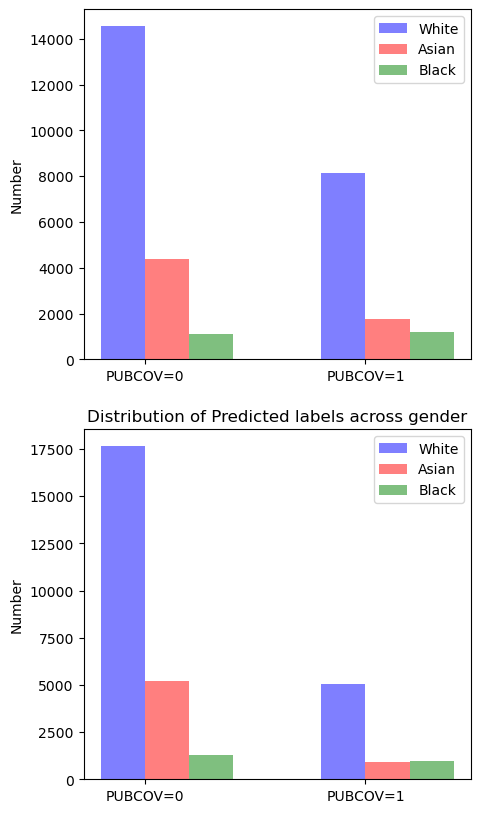

In [14]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['PUBCOV=0', 'PUBCOV=1']
values1 = [len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_0) & (df_out["true_labels"]==0)]), len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_0) & (df_out["true_labels"]==1)])]
values2 = [len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_1) & (df_out["true_labels"]==0)]), len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_1) & (df_out["true_labels"]==1)])]
values3 = [len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_2) & (df_out["true_labels"]==0)]), len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_2) & (df_out["true_labels"]==1)])]

bar_width = 0.2  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
        label='White', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
        width=bar_width, label='Asian', alpha=0.5)

# Plot the third group of bars (Bars 3 and 4)
ax[0].bar(index + 2*bar_width, values3, color='green',
        width=bar_width, label='Black', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)
# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
#ax[0].set_title('Distribution of True labels across race')
ax[0].legend()


categories2 = ['PUBCOV=0', 'PUBCOV=1']
values4 = [len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_0) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_0) & (df_out["pred_labels"]==1)])]
values5 = [len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_1) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_1) & (df_out["pred_labels"]==1)])]
values6 = [len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_2) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["RAC1P"]==SENSITIVE_CODE_2) & (df_out["pred_labels"]==1)])]

bar_width = 0.2  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values4, color='blue', width=bar_width,
        label='White', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values5, color='red',
        width=bar_width, label='Asian', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + 2*bar_width, values6, color='green',
        width=bar_width, label='Black', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)
# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
ax[1].set_title('Distribution of Predicted labels across gender')
ax[1].legend()


In [25]:
print(df_out['pred_labels'])

0       0
1       0
2       0
3       0
4       0
       ..
9044    0
9045    1
9046    1
9047    0
9048    0
Name: pred_labels, Length: 9049, dtype: int64


In [26]:
df_out

,education_code,marital_code,gender_code,occupation_code,relationship_code,country_code,hours_code,pred_labels,raw_out,true_labels
0,14,4,0,9,1,38,0,0,0.232660,1
1,11,2,0,2,0,35,0,0,0.298629,0
2,11,2,0,7,0,10,0,0,0.220500,1
3,11,2,0,2,0,38,0,0,0.356739,0
4,9,3,1,9,1,38,0,0,0.063338,0
...,...,...,...,...,...,...,...,...,...,...
9044,15,4,1,5,4,38,1,0,0.000172,0
9045,14,2,0,9,0,38,0,1,0.889948,1
9046,9,2,0,11,0,38,0,1,0.740441,1
9047,11,4,0,11,1,38,1,0,0.016289,0


In [15]:
tp_asian = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['RAC1P'] == 1)])
fp_asian = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['RAC1P'] == 1)])
tn_asian = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['RAC1P'] == 1)])
fn_asian = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['RAC1P'] == 1)])

tp_white = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['RAC1P'] == 0)])
fp_white = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['RAC1P'] == 0)])
tn_white = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['RAC1P'] == 0)])
fn_white = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['RAC1P'] == 0)])

tp_black = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['RAC1P'] == 2)])
fp_black = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['RAC1P'] == 2)])
tn_black = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['RAC1P'] == 2)])
fn_black = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['RAC1P'] == 2)])

In [16]:
fpr_asian = fp_asian/(fp_asian + tn_asian)
tpr_asian = tp_asian/(tp_asian + fn_asian)
fpr_white = fp_white/(fp_white + tn_white)
tpr_white = tp_white/(tp_white + fn_white)
fpr_black = fp_black/(fp_black + tn_black)
tpr_black = tp_black/(tp_black + fn_black)
precision_white = tp_white/(tp_white + fp_white)
precision_asian = tp_asian/(tp_asian + fp_asian)
precision_black = tp_black/(tp_black + fp_black)
f1_white = 2*precision_white*tpr_white/(precision_white + tpr_white)
f1_asian = 2*precision_asian*tpr_asian/(precision_asian + tpr_asian)
f1_black = 2*precision_black*tpr_black/(precision_black + tpr_black)
acc_white = (tp_white + tn_white) / (tp_white + tn_white + fp_white + fn_white)
acc_asian = (tp_asian + tn_asian) / (tp_asian + tn_asian + fp_asian + fn_asian)
acc_black = (tp_black + tn_black) / (tp_black + tn_black + fp_black + fn_black)

print("FPR asian", fpr_asian)
print("TPR asian", tpr_asian)
print("FPR white", fpr_white)
print("TPR white", tpr_white)
print("FPR black", fpr_black)
print("TPR black", tpr_black)
print("Precision white", precision_white)
print("Precision asian", precision_asian)
print("Precision black", precision_black)
print("F1 white", f1_white)
print("F1 asian", f1_asian)
print("F1 black", f1_black)
print("acc white", acc_white)
print("acc asian", acc_asian)
print("acc black", acc_black)

FPR asian 0.08031028975587497
TPR asian 0.32515687393040504
FPR white 0.11642754170385117
TPR white 0.41195972495088407
FPR black 0.2375
TPR black 0.6171477079796265
Precision white 0.664224905959216
Precision asian 0.6182212581344902
Precision black 0.7321248741188319
F1 white 0.5085259568018188
F1 asian 0.4261682242990654
F1 black 0.669737448180562
acc white 0.7144555501739245
acc asian 0.7498370273794003
acc black 0.6879895561357703


In [46]:
fnr_asian = fn_asian/(fn_asian + tp_asian)
tnr_asian = tn_asian/(tn_asian + fp_asian)
fnr_white = fn_white/(fn_white + tp_white)
tnr_white = tn_white/(tn_white + fp_white)
fnr_black = fn_black/(fn_black + tp_black)
tnr_black = tn_black/(tn_black + fp_black)

In [47]:
print("FNR asian", fnr_asian)
print("TNR asian", tnr_asian)
print("FNR white", fnr_white)
print("TNR white", tnr_white)
print("FNR black", fnr_black)
print("TNR black", tnr_black)

FNR asian 0.7032657657657657
TNR asian 0.9279888137963179
FNR white 0.5978942090749562
TNR white 0.8930502974580855
FNR black 0.326158940397351
TNR black 0.7209090909090909


In [21]:
precision_asian = tp_asian/(tp_asian + fp_asian)
#tpr_female = tp_female/(tp_female + fn_female)
print("Precision Asian ", precision_asian)
precision_white = tp_white/(tp_white + fp_white)
print("Precision White ", precision_white)
#tpr_male = tp_male/(tp_male + fn_male)
precision_black = tp_black/(tp_black + fp_black)
print("Precision Black ", precision_black)

Precision Female  0.6294642857142857
Precision Male  0.7448494453248812


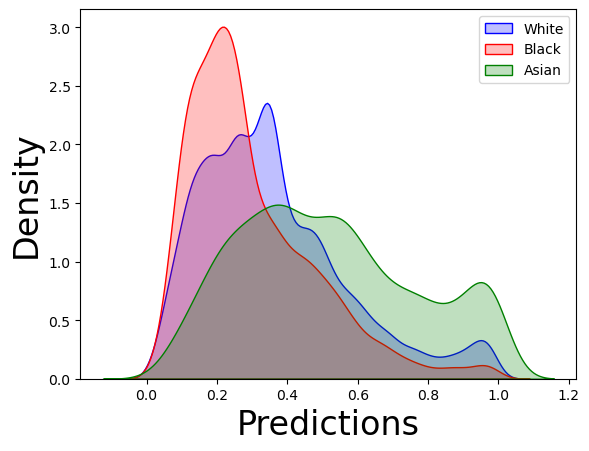

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have predictions for male and female
predictions_0 = df_out[df_out["RAC1P"]==SENSITIVE_CODE_0]["raw_out"]
predictions_1 = df_out[df_out["RAC1P"]==SENSITIVE_CODE_1]["raw_out"]
predictions_2 = df_out[df_out["RAC1P"]==SENSITIVE_CODE_2]["raw_out"]

# Create density distribution plot with normalized densities
sns.kdeplot(predictions_0.squeeze(), label='White', color='blue', fill=True, common_norm=True)
sns.kdeplot(predictions_1.squeeze(), label='Black', color='red', fill=True, common_norm=True)
sns.kdeplot(predictions_2.squeeze(), label='Asian', color='green', fill=True, common_norm=True)

# Add labels and title
plt.xlabel('Predictions', fontsize=24)
plt.ylabel('Density', fontsize=24)
#plt.title('Density Distribution conditioned on sensitive attribute')

# Show legend
plt.legend()

# Show plot
plt.show()

In [24]:
len(df_out[df_out["gender_code"]==SENSITIVE_CODE_0])

6138

In [25]:
y = df_out_scaled.values[:,-1]

(6138, 7)
(2911, 7)


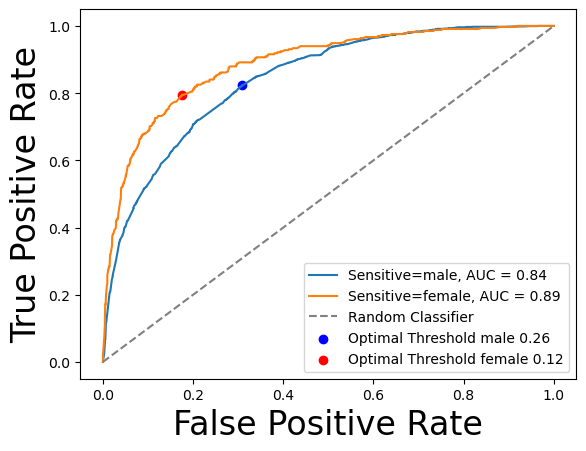

In [27]:
from sklearn.metrics import roc_curve, auc


# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tpr_minus_fpr = tpr - fpr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='blue' if sensitive_value == "male" else 'red', label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    # Plot the optimal threshold point on the ROC curve

# Set your model to evaluation mode
model.eval()

# Forward pass for subgroup with sensitive attribute A=0
with torch.no_grad():
    print(tensor_list_scaled[(tensor_list[:, 2] == SENSITIVE_CODE_0), :].shape)
    predictions_0 = model(torch.Tensor(tensor_list_scaled[(tensor_list[:, 2] == SENSITIVE_CODE_0), :]))

# Forward pass for subgroup with sensitive attribute A=1
with torch.no_grad():
    print(tensor_list_scaled[(tensor_list[:, 2] == SENSITIVE_CODE_1), :].shape)
    predictions_1 = model(torch.Tensor(tensor_list_scaled[(tensor_list[:, 2] == SENSITIVE_CODE_1), :]))

# Plot ROC for sensitive attribute A=0
plot_roc_curve_pr(predictions_0.numpy(), y[(tensor_list[:, 2] == SENSITIVE_CODE_0)], sensitive_value="male")

# Plot ROC for sensitive attribute A=1
plot_roc_curve_pr(predictions_1.numpy(), y[(tensor_list[:, 2] == SENSITIVE_CODE_1)], sensitive_value="female")

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
#plt.title('ROC Curve')
plt.legend()
plt.show()

In [28]:
len(out[(tensor_list[:, 2] == SENSITIVE_CODE_0)]) + len(out[(tensor_list[:, 2] == SENSITIVE_CODE_1)])

9049

In [29]:
type(predictions_0)

torch.Tensor